# House Pricing
Houses are expensive. For an average buyer it is quite hard to decide which house to buy. While online house retail sites somewhat alleviate that problem, the sheer amount of data that is present in them is daunting for any user. Wouldn't it be nice if there was an automated software that could predict a fair price for a house, given it's data? This is exactly why we developed this tool for.


## Data description
The first thing to do would be to take a look at our data. In this particular case, data was provided in 2 different datasets, they contain similar information, but given that they have almost the same amount of rows but a few more variables, we decided to only use the one with the most amount of information.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/data_from_json.csv')
df = df.drop(columns=['Unnamed: 0'])

Now lets see the data

In [3]:
df.tail(5)

,price,space,room,bedroom,furniture,latitude,longitude,city_area,floor,max_floor,apartment_type,renovation_type,balcony
29199,179200,75.00,2,1,0,41.761308,44.789730,Nadzaladevi District,11,22,construction,green frame,1
29200,126600,53.00,2,1,0,41.731884,44.836876,Other,8,12,new,green frame,1
29201,62400,25.75,1,1,0,41.731884,44.836876,Other,7,12,new,green frame,1
29202,167200,70.00,3,2,0,41.731884,44.836876,Other,4,12,new,green frame,1
29203,169300,75.00,3,2,0,41.731884,44.836876,Other,5,8,construction,green frame,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29204 entries, 0 to 29203
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            29204 non-null  int64  
 1   space            29204 non-null  float64
 2   room             29204 non-null  int64  
 3   bedroom          29204 non-null  int64  
 4   furniture        29204 non-null  int64  
 5   latitude         28958 non-null  float64
 6   longitude        28958 non-null  float64
 7   city_area        29204 non-null  object 
 8   floor            29204 non-null  int64  
 9   max_floor        29204 non-null  int64  
 10  apartment_type   29194 non-null  object 
 11  renovation_type  29204 non-null  object 
 12  balcony          29204 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 2.9+ MB


In [5]:
df.describe()

,price,space,room,bedroom,furniture,latitude,longitude,floor,max_floor,balcony
count,2.920400e+04,29204.000000,29204.000000,29204.000000,29204.000000,28958.000000,28958.000000,29204.000000,29204.000000,29204.000000
mean,2.988408e+05,87.569128,2.923298,1.819751,0.430592,41.729477,44.781414,6.361663,10.744556,0.776092
std,1.952151e+06,45.717693,1.050128,0.852494,0.495168,0.051541,0.083022,4.707854,5.454033,0.416868
min,3.300000e+03,13.000000,1.000000,0.000000,0.000000,40.469229,38.829869,0.000000,0.000000,0.000000
25%,1.483000e+05,57.000000,2.000000,1.000000,0.000000,41.708101,44.753788,3.000000,7.000000,1.000000
50%,2.142000e+05,75.000000,3.000000,2.000000,0.000000,41.724521,44.772078,5.000000,10.000000,1.000000
75%,3.394000e+05,105.000000,3.000000,2.000000,1.000000,41.734181,44.810649,9.000000,14.000000,1.000000
max,3.295100e+08,530.000000,14.000000,4.000000,1.000000,44.266066,47.238277,127.000000,113.000000,1.000000


It seems like we don't have clear outliers, so we will leave them because they might represent an outstanding (or very poor) location. Now lets plot the correlation matrix to see if we have some clear correlation between variables.

## Data Visualization

In [6]:
# Definition of a function to visualize correlation between variables
import seaborn as sn
import matplotlib.pyplot as plt


def plot_correlation(df):
    corr_matrix = df.corr()
    heat_map = sn.heatmap(corr_matrix, annot=False)
    plt.show(heat_map)

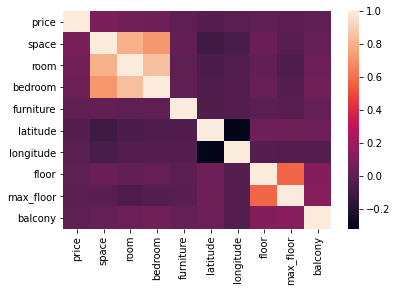

In [7]:
plot_correlation(df)

Given that our target variable is price, we cannot see a clear correlation. Lets proceed divide the data into train and test set. Using the following graph we can see that we don't have clear outliers in our dataset.

pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(10, 10));

## Data preprocessing
We will proceed to separate data into train and test. Once we have our data ready we will begin imputing and normalizing/standardizing.

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(axis=1, columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123)

Now we will separate numerical and categorical variables

In [9]:
# Numerical variable names
num_var = X_train.select_dtypes(np.number).columns
# Categorical variable names
cat_var = X_train.select_dtypes(include=['object', 'bool']).columns

### Data Cleaning
This is the time to take care of missing values, we will use KNN-Imputer to deal with numerical missing values and 'most frequent' simple imputer to deal with categorical ones

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

In [11]:
# Creating both numerical and categorical imputer
t1 = ('num_imputer', KNNImputer(n_neighbors=5), num_var)
t2 = ('cat_imputer', SimpleImputer(strategy='most_frequent'),
      cat_var)

column_transformer_cleaning = ColumnTransformer(
    transformers=[t1, t2], remainder='passthrough')

column_transformer_cleaning.fit(X_train)

Train_transformed = column_transformer_cleaning.transform(X_train)
Test_transformed = column_transformer_cleaning.transform(X_test)

# Here we update the order in wich variables are located in the dataframe, given that after transforming, we will have all
# numerical variables first, followed by all the categorical variables.
var_order = num_var.tolist() + cat_var.tolist()

# And finally we recreate the Data Frames
X_train_clean = pd.DataFrame(Train_transformed, columns=var_order)
X_test_clean = pd.DataFrame(Test_transformed, columns=var_order)

### Normalizing and Enconding data
Next step is to normalize and enconde data to achieve better performance in our models

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [13]:
# We obtain the diferent values in all categorical variables
dif_values = [df[column].dropna().unique() for column in cat_var]

In [14]:
# Now we create the transformers
t_norm = ("normalizer", MinMaxScaler(feature_range=(0, 1)), num_var)
t_nominal = ("onehot", OneHotEncoder(
    sparse=False, categories=dif_values), cat_var)
# As the dataset isn't huge, we will set sparse=false

In [15]:
column_transformer_norm_enc = ColumnTransformer(transformers=[t_norm, t_nominal],
                                                remainder='passthrough')

column_transformer_norm_enc.fit(X_train_clean);

In [16]:
X_train_transformed = column_transformer_norm_enc.transform(X_train_clean)
X_test_transformed = column_transformer_norm_enc.transform(X_test_clean)

### Unsupervised learning

In [17]:
from sklearn.cluster import KMeans

In [18]:
kmeans = KMeans(
    n_clusters=2, 
    random_state=123
).fit(X_train_transformed)

In [19]:
test_cluster = kmeans.predict(X_test_transformed)

In [20]:
X_train_transformed = np.append(X_train_transformed, np.expand_dims(kmeans.labels_, axis=1), axis=1)
X_test_transformed = np.append(X_test_transformed, np.expand_dims(test_cluster, axis=1), axis=1)

### Feature Engineering

In [21]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_train_transformed, y_train, test_size=0.30, random_state=123)

In [22]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X_val_train, y_val_train)
print(model.feature_importances_)

[1.88279024e-01 5.31595550e-02 6.62028485e-02 1.60783376e-02
 2.56854814e-01 2.30141022e-01 8.62513302e-02 6.39541243e-02
 2.50864007e-02 1.30267890e-03 1.67187181e-05 4.46828279e-05
 1.57882755e-04 8.16312705e-06 1.58674287e-05 4.82876694e-04
 2.69620735e-03 1.13453585e-05 9.23340485e-06 1.94127613e-05
 9.37150900e-05 7.44937721e-05 1.75189974e-03 1.60082869e-04
 6.19480330e-04 2.89415264e-04 1.73421107e-05 5.24741647e-03
 4.61917562e-06 4.30801101e-05 9.25929859e-04]


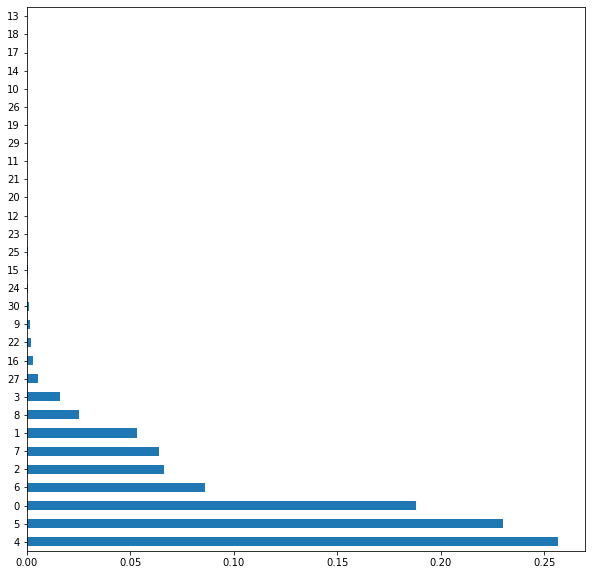

In [23]:
feat_importances = pd.Series(model.feature_importances_)
feat_importances.nlargest(30).plot(kind='barh', figsize=(10, 10))
plt.show()

In [24]:
X_train_transformed = X_train_transformed[:, [4, 5, 0, 7, 2, 6]]

In [25]:
X_test_transformed = X_test_transformed[:, [4, 5, 0, 7, 2, 6]]

### Outliers

In [26]:
df_outlier = pd.DataFrame(data=X_train_transformed)
df_outlier = df_outlier.merge(y_train, on=df_outlier.index, indicator = False).drop(axis=1, columns='key_0')

df_outlier_test = pd.DataFrame(data=X_test_transformed)
df_outlier_test = df_outlier_test.merge(y_test, on=df_outlier_test.index, indicator = False).drop(axis=1, columns='key_0')

In [27]:
df_outlier = df_outlier.rename(columns={0: "space"})

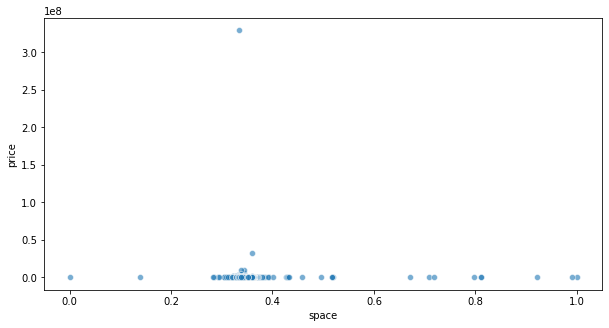

In [28]:
plt.figure(figsize=(10,5))
sn.scatterplot(x='space', y='price', 
                data=df_outlier, alpha=.6)

In [29]:
from sklearn.ensemble import IsolationForest

In [30]:
iso_forest = IsolationForest(contamination=0.5)
iso_forest.fit(df_outlier)

IsolationForest(contamination=0.5)

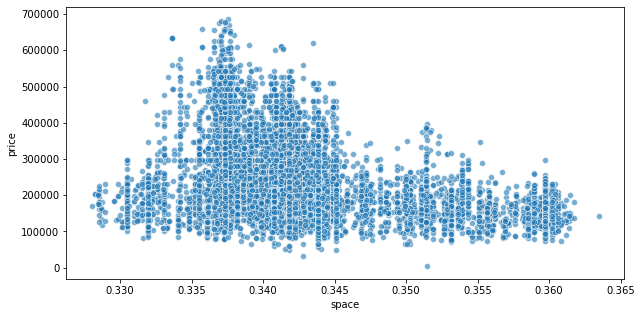

In [31]:
plt.figure(figsize=(10,5))
sn.scatterplot(x='space', y='price',
                data=df_outlier[iso_forest.predict(df_outlier) == 1], alpha=.6)

In [32]:
df_outlier = df_outlier[iso_forest.predict(df_outlier) == 1]
X_train_transformed = df_outlier.drop(axis=1, columns='price')
y_train = df_outlier['price']

In [33]:
df_outlier_test = df_outlier_test[iso_forest.predict(df_outlier_test) == 1]
X_test_transformed = df_outlier_test.drop(axis=1, columns='price')
y_test = df_outlier_test['price']

## Model Selection
We will create pipelines to fine tune hyperparameters using Grid Search. This step will take place in the train set to avoid having any contact with the test set (obviously).

In [34]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
import optuna

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [35]:
from sklearn.metrics import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    ''' Root mean squared error regression loss
    
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Ground truth (correct) target values.

    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Estimated target values.
    '''
    return np.sqrt(mean_squared_error(y_true, y_pred, squared=True))

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error, mean_squared_error

def reg_report(model, X, y):
    print(f"R2 score : {r2_score(y,model.predict(X)):.2f}")
    print(f"MAE loss : {mean_absolute_error(y,model.predict(X)):.2f}")
    print(f"RMSE loss : {np.sqrt(mean_squared_error(y,model.predict(X))):.2f}")
    print(f"error % : {np.sqrt(mean_squared_error(y,model.predict(X)))/np.mean(y):.2f}")

In [37]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(
    X_train_transformed, y_train, test_size=0.20, random_state=123)

### Grid search for Decision Tree Regressor

In [38]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=1))

depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]

param_grid_tree = [{'decisiontreeregressor__max_depth': depths,
                    'decisiontreeregressor__min_samples_leaf': num_leafs}]

In [39]:
gs_tree = GridSearchCV(estimator=pipe_tree,
                       param_grid=param_grid_tree, scoring=rmse_scorer, cv=10)
best_tree = gs_tree.fit(X_val_train, y_val_train)

In [40]:
print(reg_report(best_tree, X_val_test, y_val_test))
print('Best attributes: ', best_tree.best_params_)

R2 score : 0.73
MAE loss : 37877.02
RMSE loss : 53784.42
error % : 0.23
None
Best attributes:  {'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__min_samples_leaf': 20}


### Grid search for Linear Regression

In [41]:
pipe_lr = make_pipeline(LinearRegression())
fit_intercept = [True, False]
normalize = [True, False]
copy_x = [True, False]

parameters = [{'linearregression__fit_intercept': fit_intercept,
               'linearregression__normalize': normalize, 'linearregression__copy_X': copy_x}]

gs_lr = GridSearchCV(estimator=pipe_lr, param_grid=parameters,
                     scoring=rmse_scorer, cv=10)
best_lr=gs_lr.fit(X_val_train, y_val_train)


In [42]:
print(reg_report(best_lr, X_val_test, y_val_test))
print('Best attributes: ', best_lr.best_params_)

R2 score : 0.64
MAE loss : 45122.19
RMSE loss : 62226.74
error % : 0.27
None
Best attributes:  {'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__normalize': True}


### Grid Search for Gradient Boosting Regressor

In [43]:
ens_model = Pipeline([
    ('reg', GradientBoostingRegressor(random_state=123))
])

ens_search = GridSearchCV(
    ens_model, param_grid={
        'reg__max_depth': [number for number in np.arange(20) if number % 2 != 0],
    }
)


ens_search.fit(X_val_train, y_val_train)
ens_model = ens_search.best_estimator_

In [44]:
print(reg_report(ens_search.best_estimator_, X_val_test, y_val_test))
print(ens_search.best_params_)

R2 score : 0.78
MAE loss : 33832.28
RMSE loss : 48137.14
error % : 0.21
None
{'reg__max_depth': 7}


### Optimizing for LightGBM Regressor

In [45]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 100)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        random_state=123
    )
    return model


sampler = TPESampler(seed=123)


def objective(trial):
    model = create_model(trial)
    model.fit(X_val_train, y_val_train)
    preds = model.predict(X_val_test)
    return np.sqrt(mean_squared_error(y_val_test, preds))


study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=400)



[I 2020-12-03 11:18:03,909] A new study created in memory with name: no-name-d284e5e2-8896-4842-899b-ca9db0f977e4
[I 2020-12-03 11:18:03,949] Trial 0 finished with value: 49683.005937709844 and parameters: {'max_depth': 4, 'n_estimators': 93, 'learning_rate': 0.6908848859383762, 'num_leaves': 1595, 'min_child_samples': 99}. Best is trial 0 with value: 49683.005937709844.
[I 2020-12-03 11:18:03,972] Trial 1 finished with value: 51297.007107731624 and parameters: {'max_depth': 3, 'n_estimators': 48, 'learning_rate': 0.39211757898239874, 'num_leaves': 944, 'min_child_samples': 114}. Best is trial 0 with value: 49683.005937709844.
[I 2020-12-03 11:18:04,003] Trial 2 finished with value: 50129.70399480369 and parameters: {'max_depth': 3, 'n_estimators': 84, 'learning_rate': 0.2447593524779922, 'num_leaves': 1094, 'min_child_samples': 52}. Best is trial 0 with value: 49683.005937709844.
[I 2020-12-03 11:18:04,018] Trial 3 finished with value: 87752.9474741871 and parameters: {'max_depth': 5,

In [46]:
lgb_params = study.best_params
lgb_params['random_state'] = 123
lgb = LGBMRegressor(**lgb_params)
lgb.fit(X_val_train, y_val_train)

print(reg_report(lgb,X_val_test,y_val_test))
print(lgb_params)

R2 score : 0.79
MAE loss : 33391.78
RMSE loss : 47456.40
error % : 0.20
None
{'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.22222685669158865, 'num_leaves': 325, 'min_child_samples': 4, 'random_state': 123}


### Data Postprocessing

In [47]:
for i in range(1, 10):
    rfe = RFE(
        estimator=LGBMRegressor(
            learning_rate=lgb_params.get('learning_rate'),
            n_estimators=lgb_params.get('n_estimators'),
            max_depth=lgb_params.get('max_depth'),
            num_leaves=lgb_params.get('num_leaves'),
            min_child_samples=lgb_params.get('min_child_samples'),
            random_state=123
        ),
        n_features_to_select=i
    )
    pipeline = Pipeline(
        steps=[
            ('s', rfe),
            ('m', LGBMRegressor(
                learning_rate=lgb_params.get('learning_rate'),
                n_estimators=lgb_params.get('n_estimators'),
                max_depth=lgb_params.get('max_depth'),
                num_leaves=lgb_params.get('num_leaves'),
                min_child_samples=lgb_params.get('min_child_samples'),
                random_state=123
            ))
        ]
    )
    pipeline.fit(X_val_train, y_val_train)
    preds = pipeline.predict(X_val_test)

    print('Number of features: ', i)
    print(reg_report(pipeline, X_val_test, y_val_test))

Number of features:  1
R2 score : 0.25
MAE loss : 66934.17
RMSE loss : 89096.97
error % : 0.38
None
Number of features:  2
R2 score : 0.69
MAE loss : 40620.99
RMSE loss : 57561.01
error % : 0.25
None
Number of features:  3
R2 score : 0.75
MAE loss : 36078.46
RMSE loss : 51530.77
error % : 0.22
None
Number of features:  4
R2 score : 0.78
MAE loss : 33649.60
RMSE loss : 48451.59
error % : 0.21
None
Number of features:  5
R2 score : 0.78
MAE loss : 33594.73
RMSE loss : 48805.13
error % : 0.21
None
Number of features:  6
R2 score : 0.79
MAE loss : 33391.78
RMSE loss : 47456.40
error % : 0.20
None
Number of features:  7
R2 score : 0.79
MAE loss : 33391.78
RMSE loss : 47456.40
error % : 0.20
None
Number of features:  8
R2 score : 0.79
MAE loss : 33391.78
RMSE loss : 47456.40
error % : 0.20
None
Number of features:  9
R2 score : 0.79
MAE loss : 33391.78
RMSE loss : 47456.40
error % : 0.20
None


## Model Training
Our winner is **Gradient Boosting Regressor**. Now it's time to train that model with all of our train data to obtain the *down to earth* performance of our model.

In [48]:
model = LGBMRegressor(
    learning_rate=lgb_params.get('learning_rate'),
    n_estimators=lgb_params.get('n_estimators'),
    max_depth=lgb_params.get('max_depth'),
    num_leaves=lgb_params.get('num_leaves'),
    min_child_samples=lgb_params.get('min_child_samples'),
    random_state=123
)
model.fit(X_train_transformed, y_train)

print(reg_report(model, X_test_transformed, y_test))

R2 score : 0.79
MAE loss : 31586.87
RMSE loss : 46046.26
error % : 0.20
None


## Conclusion
To conclude, we created this tool to predict house pricing based on certain parameters. We achieved a RMSE of 46046.26 U$D